In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path

%matplotlib inline

# Physical constants

In [2]:
q0 = 1.6e-19 # electron charge in Coulomb
eV = 1.6e-19 # electron volt in Jouls

# Hyper-parameters

In [196]:
# box_size = 20 # size of the box for taking moving box average
# steady_state_reached = 20 # time step in which the steady state is reached

directory = "/Users/amirhossein/research/exciton_monte_carlo_2nm_experiment"

# read the current data

steady state drain current: 1.29e+28
steady state drain current: 4.51e+27
steady state drain current: 3.50e+27
steady state drain current: 1.06e+27
steady state drain current: 5.77e+26


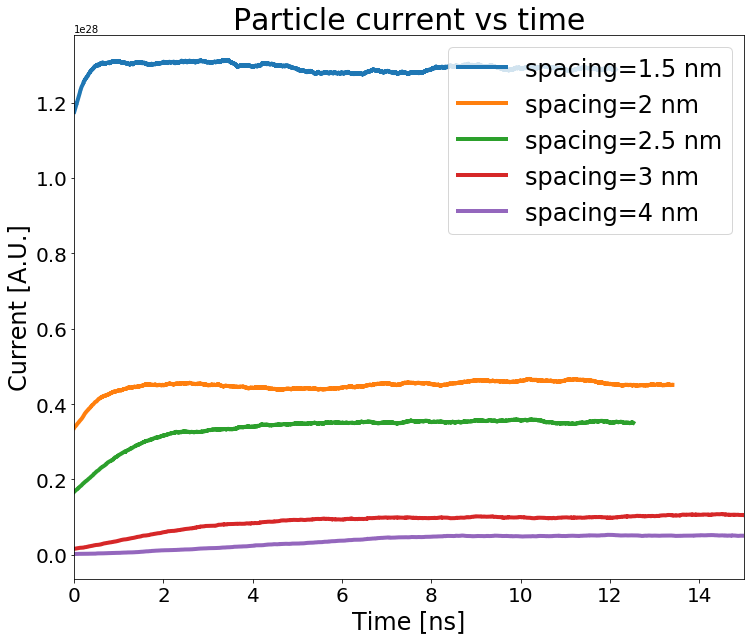

In [223]:
def plot_current(directory, box_size=3000, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "region_current.dat")
    current = np.loadtxt(filename)
    time = current[:,0]
    current = current[:,1:]
#     print("length of current array: {}".format(current.shape[0]))
    
    assert (current.shape[0] > box_size), "box_size must be smaller than the number of time steps: {}".format(current.shape[0])

    # calculate and plot box average of the data
    box = np.ones(box_size)
    smooth_current = np.zeros((current.shape[0]-box.shape[0]+1,current.shape[1]))
    for i in range(0,current.shape[1]):
        smooth_current[:,i] = np.convolve(current[:,i], box, mode='valid')/np.sum(box)
        
    print("steady state drain current: {:.2e}".format(smooth_current[-1,2]))
        
    ax.plot(time[:smooth_current.shape[0]]*1.e9,(smooth_current[:,2]), linewidth=4, color=color)
    ax.set_title("Particle current vs time",fontsize=30)
    ax.set_xlabel("Time [ns]",fontsize=24)
    ax.set_ylabel("Current [A.U.]",fontsize=24)
    ax.tick_params(labelsize=20)
    ax.legend(["source","bulk","drain"],fontsize=24)
    ax.set_xlim([0,15])
#     ax.set_ylim([-2e28,2e28])
    return ax


# plot_current(directory)

ax = plot_current("/Users/amirhossein/research/exciton_monte_carlo_1.5nm")
plot_current("/Users/amirhossein/research/exciton_monte_carlo_2nm", ax=ax)
plot_current("/Users/amirhossein/research/exciton_monte_carlo_2.5nm", ax=ax)
plot_current("/Users/amirhossein/research/exciton_monte_carlo_3nm", ax=ax)
plot_current("/Users/amirhossein/research/exciton_monte_carlo_4nm", ax=ax)

ax.legend(["spacing=1.5 nm","spacing=2 nm","spacing=2.5 nm", "spacing=3 nm", "spacing=4 nm"],fontsize=24)


(1.35, 4.05)

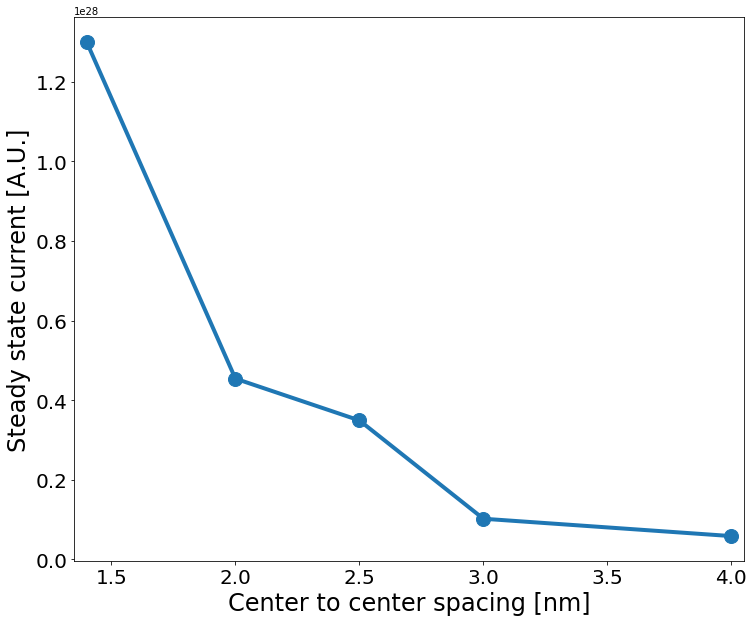

In [222]:
current = np.array([1.30e+28, 4.54e+27, 3.49e+27, 1.02e+27, 5.84e+26])
spacing = np.array([1.4, 2, 2.5, 3, 4])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.plot(spacing, current, linewidth=4, marker='o', markersize='14')
# ax.set_title("Steady state current",fontsize=30)
ax.set_xlabel("Center to center spacing [nm]",fontsize=24)
ax.set_ylabel("Steady state current [A.U.]",fontsize=24)
ax.tick_params(labelsize=20)
ax.set_xlim([1.35,4.05])

# Population profile versus time

length of population array: 50060


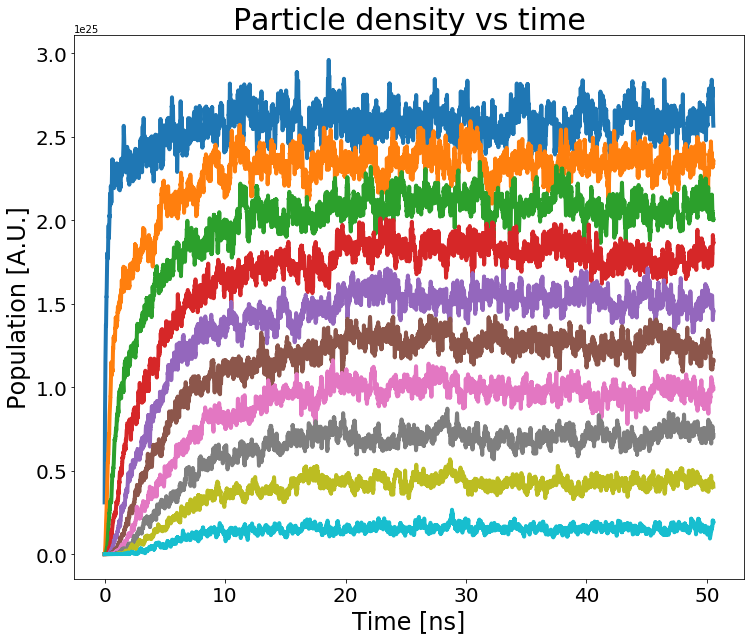

In [150]:
def plot_population_vs_time(directory, box_size=20, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "population_profile.dat")
    population = np.loadtxt(filename)
    distance = population[0,1:]
    time = population[1:,0]
    population = population[1:,1:]
    print("length of population array: {}".format(population.shape[0]))
    
    assert (population.shape[0] > box_size), "box_size must be smaller than the number of time steps: {}".format(current.shape[0])

    # calculate and plot box average of the data
    box = np.ones(box_size)
    smooth_population = np.zeros((population.shape[0]-box.shape[0]+1,population.shape[1]))
    for i in range(0,population.shape[1]):
        smooth_population[:,i] = np.convolve(population[:,i], box, mode='valid')/np.sum(box)
        
    ax.plot(time[:smooth_population.shape[0]]*1.e9,(smooth_population[:,:]), linewidth=4, color=color)
    ax.set_title("Particle density vs time",fontsize=30)
    ax.set_xlabel("Time [ns]",fontsize=24)
    ax.set_ylabel("Population [A.U.]",fontsize=24)
    ax.tick_params(labelsize=20)
#     ax.set_xlim([0,0.8])
    # ax.set_ylim([-2e29,2e29])
    return ax

plot_population_vs_time(directory)

# Population profile versus position

length of population array: 50208
time: 5.555000000000001
length of population array: 50229
time: 106.555
length of population array: 50251
time: 207.55500000000004
length of population array: 50272
time: 510.555
length of population array: 50294
time: 1066.055
length of population array: 50313
time: 26418.570000000003


Text(0.5,1,'Particle profile vs position at various time intervals')

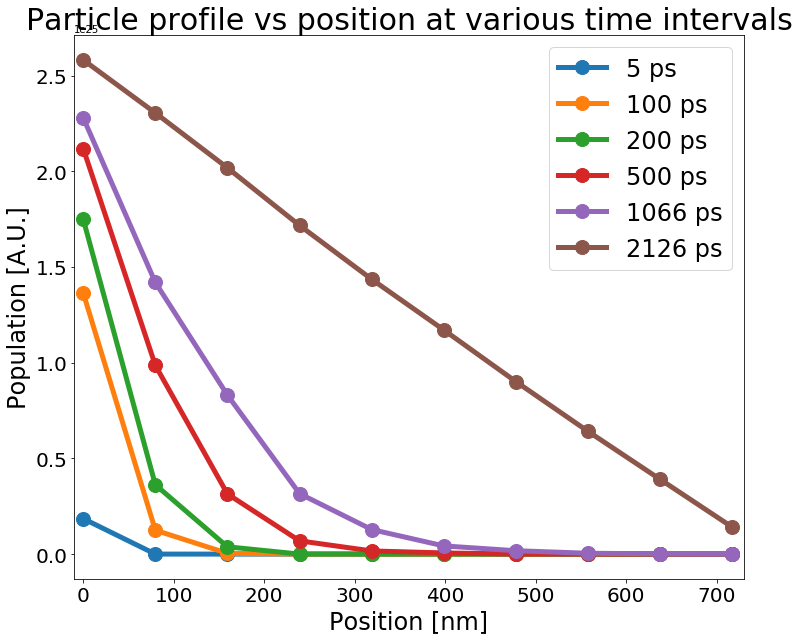

In [151]:
def plot_population_vs_position(directory, start=0, end=None, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "population_profile.dat")
    population = np.loadtxt(filename)
    distance = population[0,1:]
    time = population[1:,0]
    population = population[1:,1:]
    print("length of population array: {}".format(population.shape[0]))
    
    if (end is None):
        end = population.shape[0]
    
    assert (population.shape[0] > start), "start interval must be smaller than the number of time steps: {}".format(population.shape[0])
    avg_population = np.mean(population[start:end,:],0)
        
    ax.plot(distance*1.e9, avg_population, linewidth=5, marker='o', markersize=14, color=color)
    ax.set_title("Particle profile vs position",fontsize=30)
    ax.set_xlabel("Position [nm]",fontsize=24)
    ax.set_ylabel("Population [A.U.]",fontsize=24)
    ax.tick_params(labelsize=20)
    print("time: {}".format(np.mean(time[start:end])*1.e12))
    ax.set_xlim([-10,730])
    return ax

ax = plot_population_vs_position(directory, start=0,end=10)
ax = plot_population_vs_position(directory, start=100,end=110,ax=ax)
ax = plot_population_vs_position(directory, start=200,end=210,ax=ax)
ax = plot_population_vs_position(directory, start=500,end=510,ax=ax)
ax = plot_population_vs_position(directory, start=1000,end=1110,ax=ax)
ax = plot_population_vs_position(directory, start=2000,end=None,ax=ax)
ax.legend(["5 ps","100 ps", "200 ps", "500 ps", "1066 ps", "2126 ps"], fontsize=24)
ax.set_title("Particle profile vs position at various time intervals",fontsize=30)

# Plot current data for multiple simulations

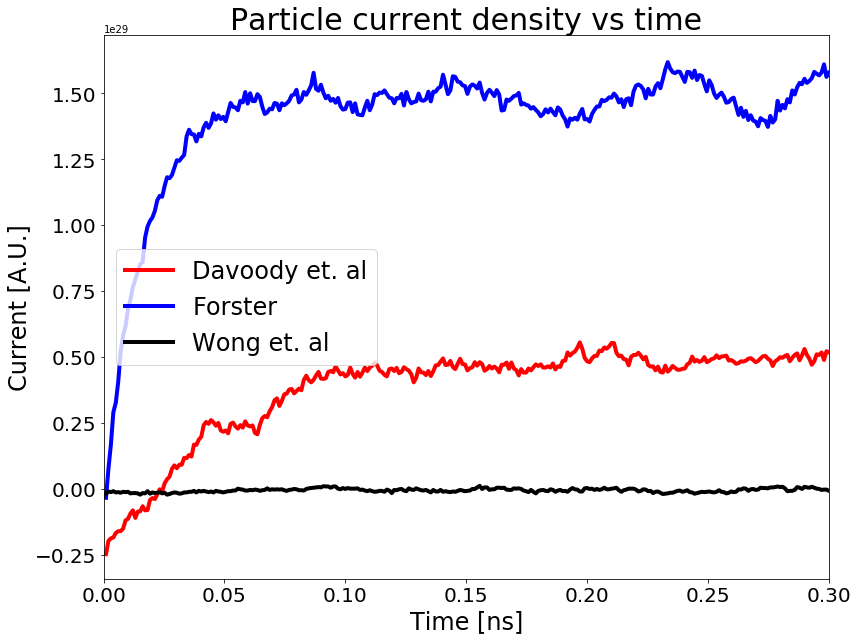

In [101]:
def plot_current(directory, box_size=20,color=None):
    filename = os.path.join(directory, "region_current.dat")
    current = np.loadtxt(filename)
    time = current[:,0]
    current = current[:,1:]
    
    assert (current.shape[0] > box_size), "box_size must be smaller than the number of time steps: {}".format(current.shape[0])

    # calculate and plot box average of the data
    box = np.ones(box_size)
    smooth_current = np.zeros((current.shape[0]-box.shape[0]+1,current.shape[1]))
    for i in range(0,current.shape[1]):
        smooth_current[:,i] = np.convolve(current[:,i], box, mode='valid')/np.sum(box)
        
    plt.plot(time[:smooth_current.shape[0]]*1.e9,(smooth_current[:,2]), linewidth=4, color=color)
    plt.title("Particle current density vs time",fontsize=30)
    plt.xlabel("Time [ns]",fontsize=24)
    plt.ylabel("Current [A.U.]",fontsize=24)
    plt.xticks(fontsize=20, rotation=0)
    plt.yticks(fontsize=20, rotation=0)
    plt.xlim([0,0.3])
#     plt.ylim([-2e29,2e29])

plt.figure(figsize=(13,10))

box_size = 20

plot_current("/Users/amirhossein/research/exciton_monte_carlo_davoody", box_size, color="red")
plot_current("/Users/amirhossein/research/exciton_monte_carlo_forster", box_size, color="blue")
plot_current("/Users/amirhossein/research/exciton_monte_carlo_wong", box_size, color="black")

plt.legend(["Davoody et. al", "Forster", "Wong et. al"], fontsize=24)